In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
!pip install pydtmc
!pip install river==0.19.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 41.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


## **Data generator according to an hidden Markov Chain**
## Part 1
The aim of this notebook is to generate data according to a Markov Chain with three states. To each state we assign a Gaussian distribution with mean $\mu_i$ and variance $\sigma_i^2$ with $ i=0,1,2 $. A little bit of notation: we call $S_0$, $S_1$,$S_2$ the three states and $p_{ij}$ the probability of going to state $j$ starting from state $i$. The states are such that
$$S_i \sim \mathcal{N}(\mu_i, \sigma_i^2)  $$     
for  $ i=0,1,2 $.



We create the function "generate_data_stream()" that will take as parameters the list of the distributions (distribution_list) associated to each state, the list of the parameters (param_list) associated to the distributions, the number of points generated for each transition $n$, the total number of points generated N, the 3x3 transition matrix P.


In [ ]:

def generate_data_stream(distribution_list, param_list,n,N,P):
  """ This function generates a data stream according to a Markov Chain: at each iteration
  we generate the next state of the chain and we sample n points from the distribution
  associated to this state. The parameters of the distribution are contained
  in the list param_list. We repeat this process until we reach N data points
  generated. We return also the list 'sequence' in which are stored the states visited by the chain. """

  rng = np.random.default_rng(12345)

  data_stream=[]
  n_iter=int(N/n)
  curr_state=0
  states=[]
  for i in range(n_iter):
    next_state=int(rng.choice([0,1,2], size=1, replace=True, p=np.ravel(P[curr_state,]))[0])  #we extract the next_state according to the transition matrix P of the chain
    random_numbers=eval('rng.'+distribution_list[next_state]+'('+param_list[next_state]+',n)')  #we generate data from the normal associated to the next_state
    data_stream=np.concatenate((data_stream,random_numbers))
    curr_state=int(next_state)  #we update the current state
    states=states+[curr_state] #we keep track of the states visited by the chain

  return data_stream, states



In [ ]:
help(generate_data_stream)

Help on function generate_data_stream in module __main__:

generate_data_stream(distribution_list, param_list, n, N, P)
    This function generates a data stream according to a Markov Chain: at each iteration
    we generate the next state of the chain and we sample n points from the distribution
    associated to this state. The parameters of the distribution are contained
    in the list param_list. We repeat this process until we reach N data points
    generated. We return also the list 'sequence' in which are stored the states visited by the chain.



We also define a function plot_markov_chain() that takes as input the transition matrix P and plots the graph of the chain with the transition probability for each edge.

In [ ]:
 from pydtmc import MarkovChain
 from pydtmc import plot_graph

 def plot_markov_chain(transition_matrix):
    mc = MarkovChain(transition_matrix, states=['0','1','2'])
    plot_graph(mc, dpi=300)

Now we define the function plot_data() that plots the sequence of states visited by the chain and the data generated. Each colour represents a state.

In [ ]:
def plot_data(sequence, data_stream, n, N):
  print(sequence)
  color_mapping = {0: 'red', 1: 'green', 2: 'blue'}

  for i in range(int(N/n)):
    plt.plot(list(range(i * n, (i + 1) * n)), data_stream[i*n:(i+1)*n], 'o-', color=color_mapping[sequence[i]], linewidth=0.01, markersize=1.2)

Let's now use our function with a deterministic chain: from state 0 we go to state 1, from 1 we go to 2 and from 2 we go to 0. We use as means 0, 10 and 50 in order to have a big difference between the three distributions and understand how the function works.

[1, 2, 0, 1, 2, 0, 1, 2, 0, 1]


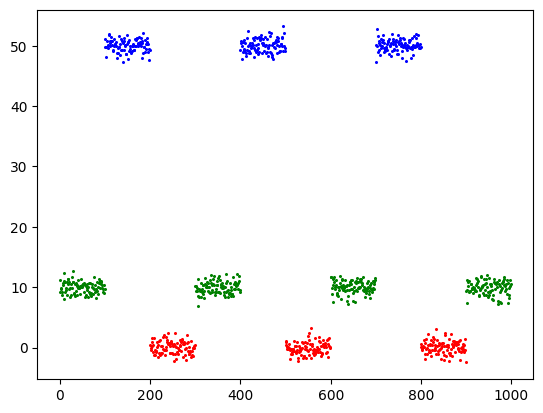

In [ ]:
n=100
N=1000
distribution_list=['normal','normal','normal']
param_list=['0,1','10,1','50,1']
P=np.array([[0,1,0],[0,0,1],[1,0,0]])
data_stream, sequence = generate_data_stream(distribution_list,param_list,n,N,P)
plot_data(sequence, data_stream, n, N)

We actually see that the transitions are deterministic and the difference between the states is very clear.

We now make a plot of our chain:

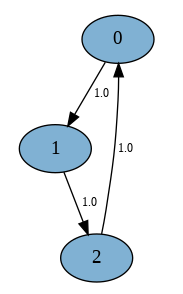

In [ ]:
plot_markov_chain(P)

Now let's modify our chain slightly: we pass to the **stochastic** case and, in particular, we assume that if our current state is $i$ the chain can either go to the next state or stay in $i$. For the moment, we maintain the assumption that the process is **sequential** (e.g. we can't go directly from state 1 to state 0)

[0, 1, 2, 0, 0, 1, 1, 1, 1, 1]


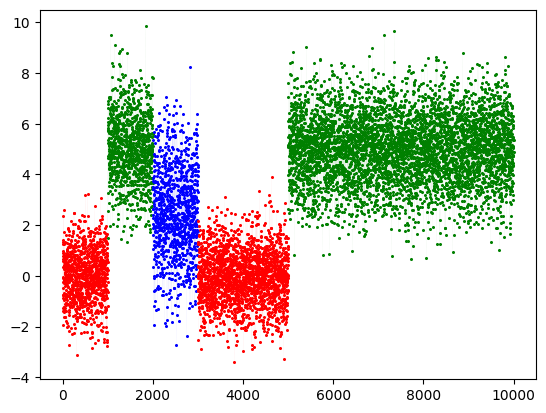

In [ ]:
n=1000
N=10000
distribution_list=['normal','normal','normal']
param_list=['0,1','5,1.3','2.5,1.7']
P=np.array([[0.3,0.7,0],[0,0.5,0.5],[0.4,0,0.6]])
data_stream , sequence = generate_data_stream(distribution_list,param_list,n,N,P)
plot_data(sequence, data_stream, n, N)

Notice that now the chain is not anymore deterministic: when I'm in the red state one time I stay, the other I move on to the next state (the green one).

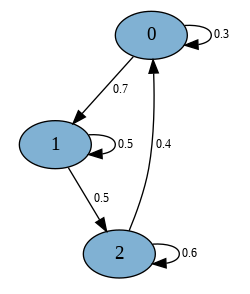

In [ ]:
plot_markov_chain(P)

Now we move on to the more general case abandoning sequentiality. We change also the means in order to have our data close to each other.

[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


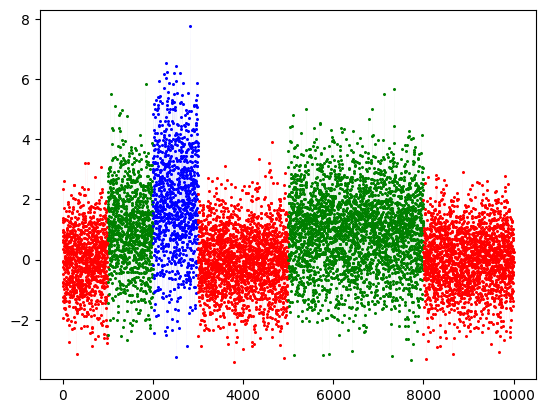

In [ ]:
n=1000
N=10000
distribution_list=['normal','normal','normal']
param_list=['0,1','1,1.3','2,1.7']
P=np.array([[0.3,0.5,0.2],[0.2,0.3,0.5],[0.4,0.3,0.3]])
data_stream ,sequence = generate_data_stream(distribution_list,param_list,n,N,P)
plot_data(sequence, data_stream, n, N)

Now the values are more concentrated: we expect concept drift detectors to have more difficulty detecting the change in distribution.

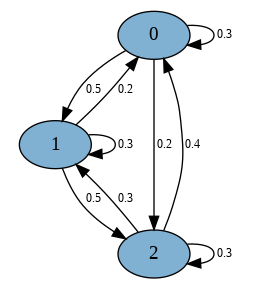

In [ ]:
plot_markov_chain(P)

We can also consider the case in which the transitions have all the same probabilities.

[0, 1, 2, 0, 0, 1, 0, 0, 0, 0]


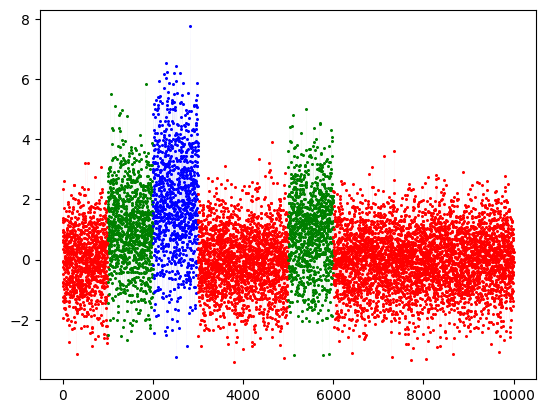

In [ ]:
n=1000
N=10000
distribution_list=['normal','normal','normal']
param_list=['0,1','1,1.3','2,1.7']
P=np.array([[0.33,0.33,0.34],[0.33,0.33,0.34],[0.33,0.33,0.34]])
data_stream, sequence = generate_data_stream(distribution_list,param_list,n,N,P)
plot_data(sequence, data_stream, n, N)

***Remark***

The data obtained are counterintuitive. It is important to note that there is a substantial difference between the stochastic process and its realization. The chain was defined in such a way that the transition probabilities were all the same but this doesn't mean that in practise is not possibile to have a chain remaining in the same state for a few steps.

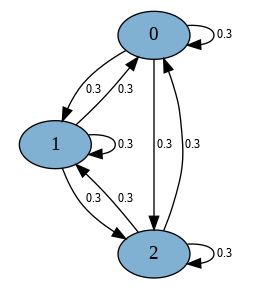

In [ ]:
plot_markov_chain(P)

##Part 2
In part 1 we created some simulated data stream according to a Markov Chain: each time we leave a state we have a concept drift. The aim of part 2 is to test the concept drift detectors seen during the course on the generated data. The goal is to detect that a drift has occured each time we leave the current state.

We start analyzing the deterministic case:

[1, 2, 0, 1, 2, 0, 1, 2, 0, 1]


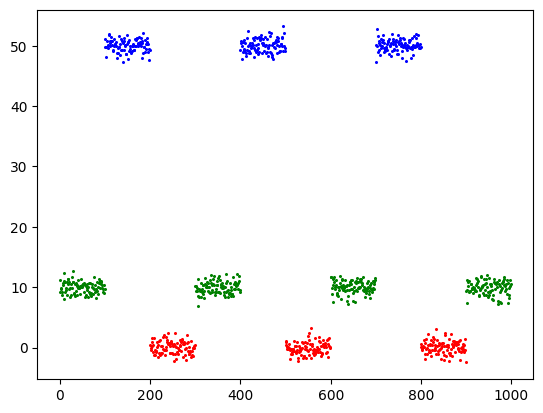

In [ ]:
n=100
N=1000
distribution_list=['normal','normal','normal']
param_list=['0 , 1','10 , 1','50 , 1']
P=np.array([[0,1,0],[0,0,1],[1,0,0]])
data_stream, sequence = generate_data_stream(distribution_list,param_list,n,N,P)
plot_data(sequence, data_stream, n, N)

We expect the concept drift detectors to work in the right way here: there is a substantial difference between the three distributions.

# **ADWIN**
ADWIN (ADaptive WINdowing) is a popular drift detection method. ADWIN efficiently keeps a variable-length window of recent items; such that it holds that there has no been change in the data distribution. This window is further divided into two sub-windows $W_0$, $W_1$
 used to determine if a change has happened. ADWIN compares the average of $W_0$ and $W_1$ to confirm that they correspond to the same distribution. Concept drift is detected if the distribution equality no longer holds. Upon detecting a drift, $W_0$ is replaced by $W_1$ and a new $W_1$ is initialized. More informations here https://riverml.xyz/0.19.0/api/drift/ADWIN/.

In [ ]:
from river.drift import ADWIN

adwin = ADWIN()
changes=[]

for i, val in enumerate(data_stream):
    _ = adwin.update(val)
    if adwin.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 127, input value: 48.02475233212759
Change detected at index 223, input value: -1.0306658539867677
Change detected at index 319, input value: 9.289553389238657
Change detected at index 415, input value: 51.22651895588983
Change detected at index 543, input value: 0.8548347926475606
Change detected at index 639, input value: 8.47655056263821
Change detected at index 735, input value: 51.88072206414997
Change detected at index 831, input value: -0.15004012557106503
Change detected at index 927, input value: 11.014799307772785


To get a clearer idea of ​​what is happening let's analyze the following plot:

[1, 2, 0, 1, 2, 0, 1, 2, 0, 1]


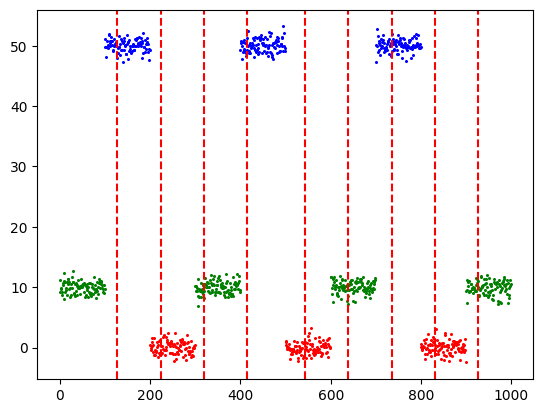

In [ ]:
plot_data(sequence, data_stream, n, N)
vertical_lines = changes  # Positions of the vertical lines

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

Drifts are correctly detected more or less after 30 data points.

# **Page Hinkley**
This change detection method works by computing the observed values and their mean up to the current moment. Page-Hinkley does not signal warning zones, only change detections. The method works by means of the Page-Hinkley test. In general lines it will detect a concept drift if the observed mean at some instant is greater then a threshold value lambda. Read more here https://riverml.xyz/0.19.0/api/drift/PageHinkley/.


In [ ]:
from river.drift import PageHinkley

ph = PageHinkley()
changes=[]
for i, val in enumerate(data_stream):
    _ = ph.update(val)
    if ph.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 101, input value: 51.06383087466723
Change detected at index 200, input value: 0.4657167185098039
Change detected at index 305, input value: 11.356381011676541
Change detected at index 400, input value: 49.33810064437242
Change detected at index 500, input value: 1.1315512191882606
Change detected at index 603, input value: 9.810203890673336
Change detected at index 701, input value: 50.05114089374223
Change detected at index 800, input value: 0.10716797851233985
Change detected at index 905, input value: 10.151235851543998


[1, 2, 0, 1, 2, 0, 1, 2, 0, 1]


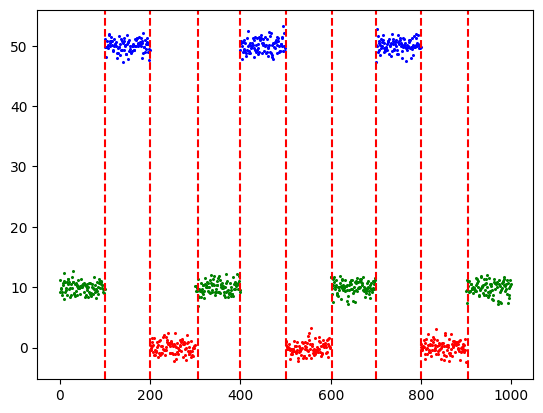

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

Results are very good: the drifts are detected after very few points and, of course, the more the distributions are similar (red and green ones) the more datapoints are needed.

# **KSWIN**
KSWIN (Kolmogorov-Smirnov Windowing) is a concept change detection method based on the Kolmogorov-Smirnov (KS) statistical test. KS-test is a statistical test with no assumption of underlying data distribution. KSWIN can monitor data or performance distributions. More informations here https://riverml.xyz/0.19.0/api/drift/KSWIN/. In short, the KS-test is performed on two windows of the same size and compares the distance of the empirical cumulative data distribution.



In [ ]:
from river import drift

kswin = drift.KSWIN( seed=42)
changes=[]

for i, val in enumerate(data_stream):
    _ = kswin.update(val)
    if kswin.drift_detected:
      changes.append(i)
      print(f"Change detected at index {i}, input value: {val}")

Change detected at index 112, input value: 50.39249438855179
Change detected at index 213, input value: -0.5574688991187301
Change detected at index 313, input value: 8.3674805230381
Change detected at index 413, input value: 48.874424754968665
Change detected at index 513, input value: -0.17272467537457903
Change detected at index 613, input value: 8.653813383555727
Change detected at index 713, input value: 50.64909123795877
Change detected at index 813, input value: -0.06916807665323477
Change detected at index 913, input value: 9.737084380964031


[1, 2, 0, 1, 2, 0, 1, 2, 0, 1]


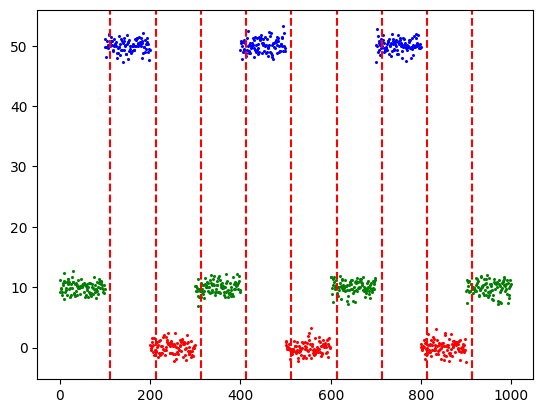

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

The drifts are detected after 12/13 points.

From the plots above we can cocnlude that, in this case, the best concept drift detector is the Page Hinkley. Also KSWIN gives nice results.

Let's pass to the **stochastic** case and, in particular, we assume **sequentiality**.

[0, 1, 2, 0, 0, 1, 1, 1, 1, 1]


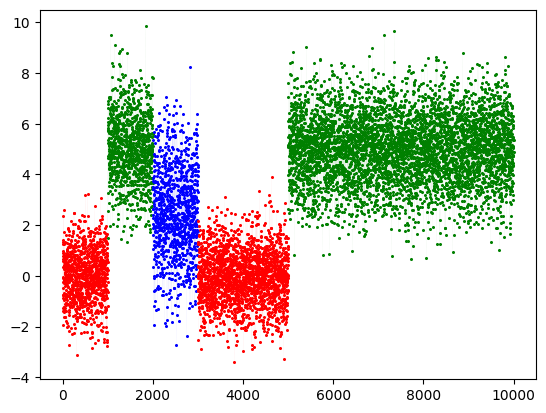

In [ ]:
n=1000
N=10000
distribution_list=['normal','normal','normal']
param_list=['0,1','5,1.3','2.5,1.7']
P=np.array([[0.3,0.7,0],[0,0.5,0.5],[0.4,0,0.6]])
data_stream, sequence = generate_data_stream(distribution_list,param_list,n,N,P)
plot_data(sequence, data_stream, n, N)

**ADWIN**

In [ ]:
from river.drift import ADWIN

adwin = ADWIN()
changes=[]

for i, val in enumerate(data_stream):
    _ = adwin.update(val)
    if adwin.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 1023, input value: 2.8609316315322806
Change detected at index 2047, input value: 0.8677897730410808
Change detected at index 3071, input value: -0.10242666682288133
Change detected at index 5055, input value: 5.834754288717733


[0, 1, 2, 0, 0, 1, 1, 1, 1, 1]


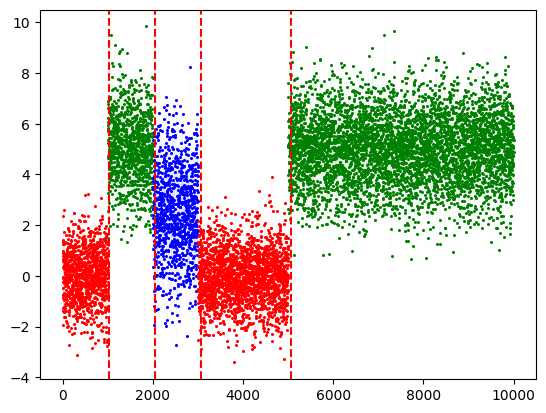

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

The changes are correctly detected. We observe again that when the difference in the distributions is high the more data points are needed.

**Page Hinkley**

In [ ]:
from river.drift import PageHinkley

ph = PageHinkley()
changes=[]
for i, val in enumerate(data_stream):
    _ = ph.update(val)
    if ph.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 1006, input value: 5.246395043153891
Change detected at index 1532, input value: 1.8364943931821802
Change detected at index 2002, input value: 2.276053701154681
Change detected at index 2593, input value: -0.7267636908702215
Change detected at index 2824, input value: 1.113444558385127
Change detected at index 3019, input value: -0.7582070621157024
Change detected at index 5006, input value: 3.9849740825836015
Change detected at index 5596, input value: 3.5262579244838332
Change detected at index 6077, input value: 3.4434093143579236
Change detected at index 6529, input value: 2.3881635674415387
Change detected at index 7733, input value: 0.6520753891393021
Change detected at index 8357, input value: 5.723643743948028
Change detected at index 8999, input value: 3.962395295361084
Change detected at index 9344, input value: 6.601702286882737


[0, 1, 2, 0, 0, 1, 1, 1, 1, 1]


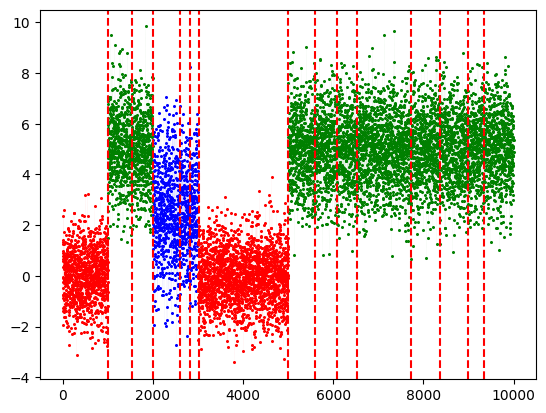

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')


We clearly see that in this case the concept drift detector is too sensitive. After having properly modified the threshold ($\lambda$) parameter (default value is 50) of the Page Hinkley detector we obtain:

In [ ]:
from river.drift import PageHinkley

ph = PageHinkley(threshold=110)
changes=[]
for i, val in enumerate(data_stream):
    _ = ph.update(val)
    if ph.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 1016, input value: 5.723865085514592
Change detected at index 2003, input value: 1.0418226886273756
Change detected at index 3031, input value: -1.2334677734836434
Change detected at index 5018, input value: 3.774974309611197


[0, 1, 2, 0, 0, 1, 1, 1, 1, 1]


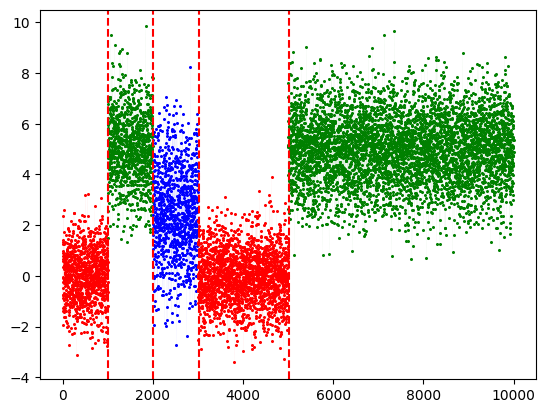

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

Increasing $\lambda$ the drift detector is less sensitive (the drift is detected when we are more sure of it).

**KSWIN**

In [ ]:
from river import drift

kswin = drift.KSWIN( seed=42)
changes=[]

for i, val in enumerate(data_stream):
    _ = kswin.update(val)
    if kswin.drift_detected:
      changes.append(i)
      print(f"Change detected at index {i}, input value: {val}")

Change detected at index 1012, input value: 5.349171633134387
Change detected at index 1133, input value: 5.723827184741647
Change detected at index 1611, input value: 3.60539208531918
Change detected at index 2018, input value: -1.921238589781499
Change detected at index 2641, input value: 2.869036497993429
Change detected at index 2816, input value: 3.223448786954886
Change detected at index 3019, input value: -0.7582070621157024
Change detected at index 4273, input value: 2.35759545562902
Change detected at index 5013, input value: 4.138185765466356
Change detected at index 6079, input value: 3.7054619288740334
Change detected at index 7031, input value: 4.246750398855836
Change detected at index 7565, input value: 4.500164529920738
Change detected at index 8456, input value: 6.61991053659923
Change detected at index 8634, input value: 5.34550497558275


[0, 1, 2, 0, 0, 1, 1, 1, 1, 1]


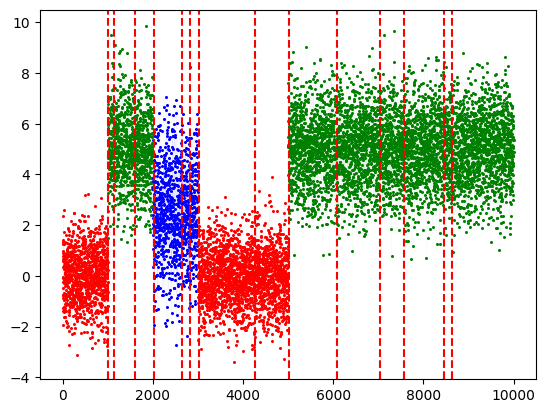

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

Again the detector is too sensitive. If we properly set the value of the alpha parameter (default value is 0.05) we obtain:

In [ ]:
from river import drift

kswin = drift.KSWIN( alpha=0.0002,seed=42)
changes=[]

for i, val in enumerate(data_stream):
    _ = kswin.update(val)
    if kswin.drift_detected:
      changes.append(i)
      print(f"Change detected at index {i}, input value: {val}")

Change detected at index 1017, input value: 4.394574907268846
Change detected at index 2022, input value: 2.746646518293502
Change detected at index 3022, input value: 1.5960042331822821
Change detected at index 5014, input value: 5.5715307007596


[0, 1, 2, 0, 0, 1, 1, 1, 1, 1]


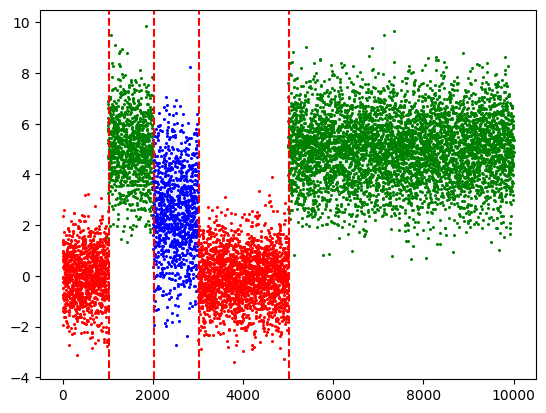

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

The alpha parameter is very sensitive, therefore should be set below 0.01 (see https://riverml.xyz/0.19.0/api/drift/KSWIN/).

Now we move to the most general case

[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


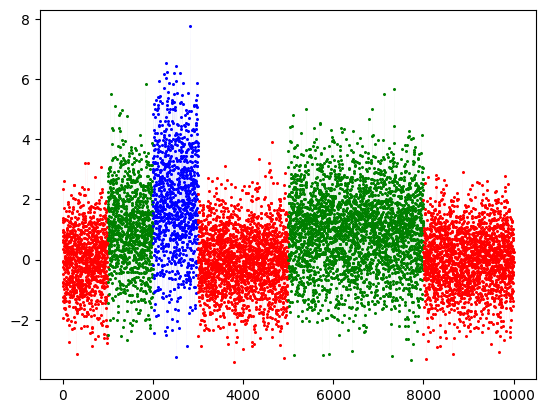

In [ ]:
n=1000
N=10000
distribution_list=['normal','normal','normal']
param_list=['0,1','1,1.3','2,1.7']
P=np.array([[0.3,0.5,0.2],[0.2,0.3,0.5],[0.4,0.3,0.3]])
data_stream ,sequence = generate_data_stream(distribution_list,param_list,n,N,P)
plot_data(sequence, data_stream, n, N)


**ADWIN**

In [ ]:
from river.drift import ADWIN

adwin = ADWIN()
changes=[]

for i, val in enumerate(data_stream):
    _ = adwin.update(val)
    if adwin.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 1087, input value: -0.22362308270912634
Change detected at index 2175, input value: 2.008797917695145
Change detected at index 3071, input value: -0.10242666682288133
Change detected at index 5151, input value: 2.153221885338412
Change detected at index 8383, input value: -0.6290785649708502


[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


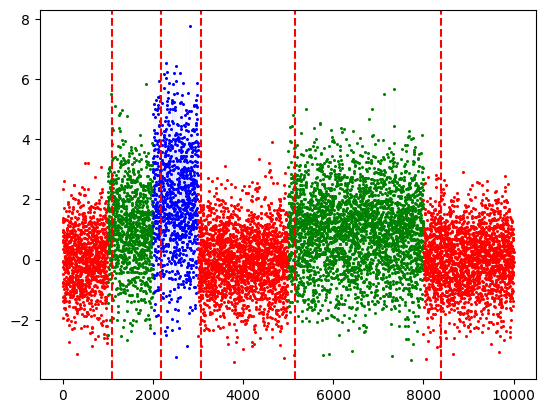

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

ADWIN properly identifies the drifts but it needs a large number of iterations.

**Page Hinkley**


In [ ]:
from river.drift import PageHinkley

ph = PageHinkley()
changes=[]
for i, val in enumerate(data_stream):
    _ = ph.update(val)
    if ph.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 1028, input value: 1.1257521248123652
Change detected at index 1532, input value: -2.16350560681782
Change detected at index 2048, input value: 2.847427613590663
Change detected at index 2593, input value: -1.2267636908702215
Change detected at index 2824, input value: 0.6134445583851269
Change detected at index 3028, input value: -1.2498762810985202
Change detected at index 3650, input value: 1.430618018958446
Change detected at index 4358, input value: 3.3312325880475884
Change detected at index 5026, input value: 1.8693700720039301
Change detected at index 5596, input value: -0.47374207551616676
Change detected at index 6077, input value: -0.5565906856420766
Change detected at index 6529, input value: -1.6118364325584613
Change detected at index 7733, input value: -3.347924610860698
Change detected at index 8061, input value: -3.3076536258105143
Change detected at index 9023, input value: -1.2692871765081601


[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


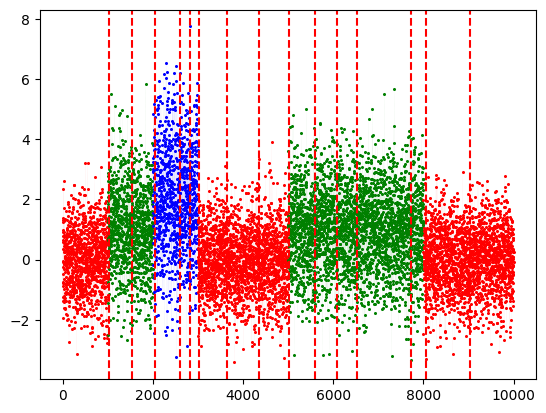

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

Too many drifts are detected.

If we properly set the value of $\lambda$ = 110 we obtain:

In [ ]:
from river.drift import PageHinkley

ph = PageHinkley(threshold=110)
changes=[]
for i, val in enumerate(data_stream):
    _ = ph.update(val)
    if ph.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 1078, input value: 1.4228913374969778
Change detected at index 2122, input value: 5.407442903861127
Change detected at index 3037, input value: -0.20751365900275606
Change detected at index 5096, input value: 1.8978899909142355
Change detected at index 8061, input value: -3.3076536258105143


[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


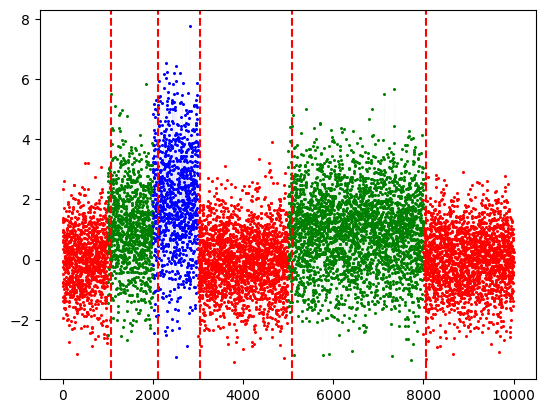

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

**KSWIN**

In [ ]:
from river import drift

kswin = drift.KSWIN(seed=42)
changes=[]

for i, val in enumerate(data_stream):
    _ = kswin.update(val)
    if kswin.drift_detected:
      changes.append(i)
      print(f"Change detected at index {i}, input value: {val}")

Change detected at index 1017, input value: 0.39457490726884603
Change detected at index 2026, input value: 4.081925082696042
Change detected at index 2647, input value: 2.3431446763336488
Change detected at index 3019, input value: -0.7582070621157024
Change detected at index 4273, input value: 2.35759545562902
Change detected at index 5016, input value: 1.2542003918355933
Change detected at index 5976, input value: 3.4282626230659594
Change detected at index 7110, input value: -1.608981501829418
Change detected at index 8025, input value: -1.0258381207694915
Change detected at index 8455, input value: -1.1857138311568765


[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


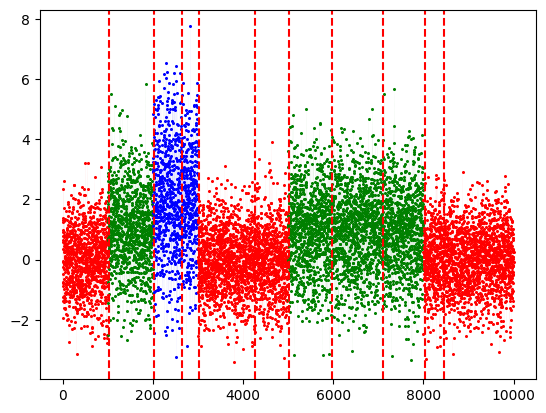

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

After having properly modified the alpha parameter (default value is 0.005) of the KSWIN detector we obtain:

In [ ]:
from river import drift

kswin = drift.KSWIN(alpha=0.0002, seed=42)
changes=[]

for i, val in enumerate(data_stream):
    _ = kswin.update(val)
    if kswin.drift_detected:
      changes.append(i)
      print(f"Change detected at index {i}, input value: {val}")

Change detected at index 3021, input value: 0.9354192762270264
Change detected at index 5020, input value: 0.002635257126756163
Change detected at index 8029, input value: 0.45084546562410066


[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


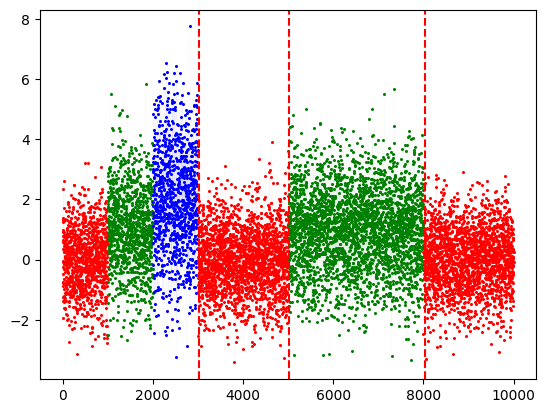

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

You can check that if you try to change the $\alpha$ parameter the drifts are never detcted correctly. When $\alpha$ is too large (small) too many (few) drifts are detected. In particular, the drifts that are more difficult to be detcted are the ones with similar distributions and with a shorter length.

We now consider one last case in which we consider the same means for the gaussians but different variances.

[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


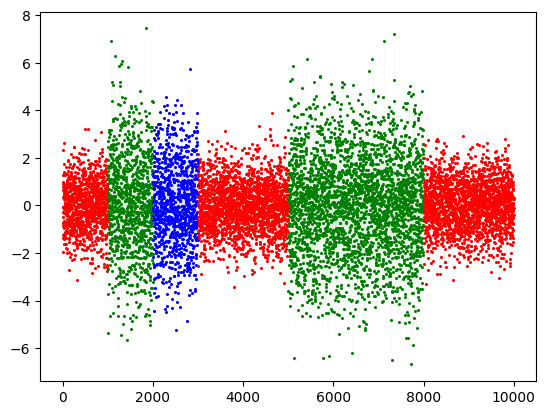

In [ ]:
n=1000
N=10000
distribution_list=['normal','normal','normal']
param_list=['0,1','0,2','0,1.7']
P=np.array([[0.3,0.5,0.2],[0.2,0.3,0.5],[0.4,0.3,0.3]])
data_stream ,sequence = generate_data_stream(distribution_list,param_list,n,N,P)
plot_data(sequence, data_stream, n, N)

Here the distributions are very similar (only the mean changes). We expect this task to be challenging for the detectors.

**ADWIN**

In [ ]:
from river.drift import ADWIN

adwin = ADWIN()
changes=[]

for i, val in enumerate(data_stream):
    _ = adwin.update(val)
    if adwin.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


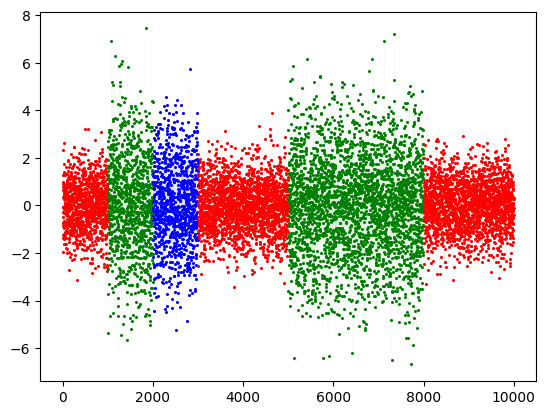

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

As expected the changes in the distrubutions are not detected.

**Page Hinkley**

In [ ]:
from river.drift import PageHinkley

ph = PageHinkley(threshold=70)
changes=[]
for i, val in enumerate(data_stream):
    _ = ph.update(val)
    if ph.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 1135, input value: 0.28760789825388827
Change detected at index 1804, input value: -0.6681771613435477
Change detected at index 2311, input value: 4.231607400585524
Change detected at index 5806, input value: 3.411873978627116
Change detected at index 6885, input value: 0.35932854942223535
Change detected at index 7859, input value: -1.2384863334908693


[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


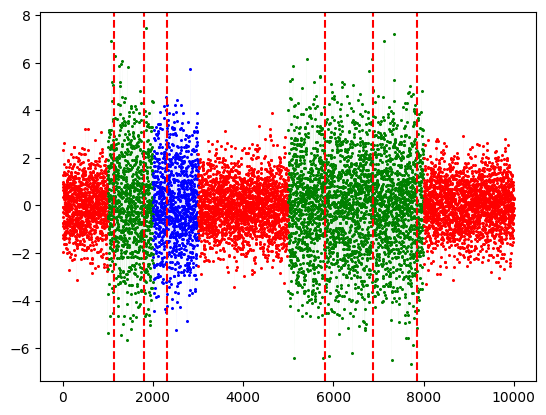

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

With Page Hinkley some drifts are correctly detected and some others not.

**KSWIN**

In [ ]:
from river import drift

kswin = drift.KSWIN( alpha=0.0025,seed=42)
changes=[]

for i, val in enumerate(data_stream):
    _ = kswin.update(val)
    if kswin.drift_detected:
      changes.append(i)
      print(f"Change detected at index {i}, input value: {val}")

Change detected at index 8445, input value: -0.5609714608916134
Change detected at index 8889, input value: -0.4540384264163666
Change detected at index 9935, input value: -0.41922685618877525


[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


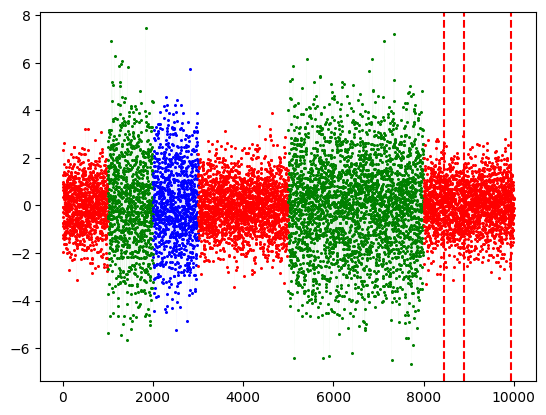

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

Also in this case we don't find a value of $\alpha$ that is suited for this task.

## Part 3


The aim of this part is to understand if there is a time dependence between datapoints of the sequences generated until now. We will explore this dependence through the autocorrelation plot and the partial autocorrelation plot. <br>
Let's see the idea behind these two concepts:

- *Autocorrelation function* (**ACF**): at lag k, it is the correlation between values ​​in the series that are separated by k intervals.
- *Partial autocorrelation function* (**PACF**): at lag k, it is the correlation between the values ​​in the series that are separated by k intervals, taking into account the values ​​of the intervals in between. The key difference with respect to ACF is the exclusion of ***indirect correlations*** in the calculation.

We now analyse all the data streams seen until now.

[1, 2, 0, 1, 2, 0, 1, 2, 0, 1]
[0, 1, 2, 0, 0, 1, 1, 1, 1, 1]
[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]
[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


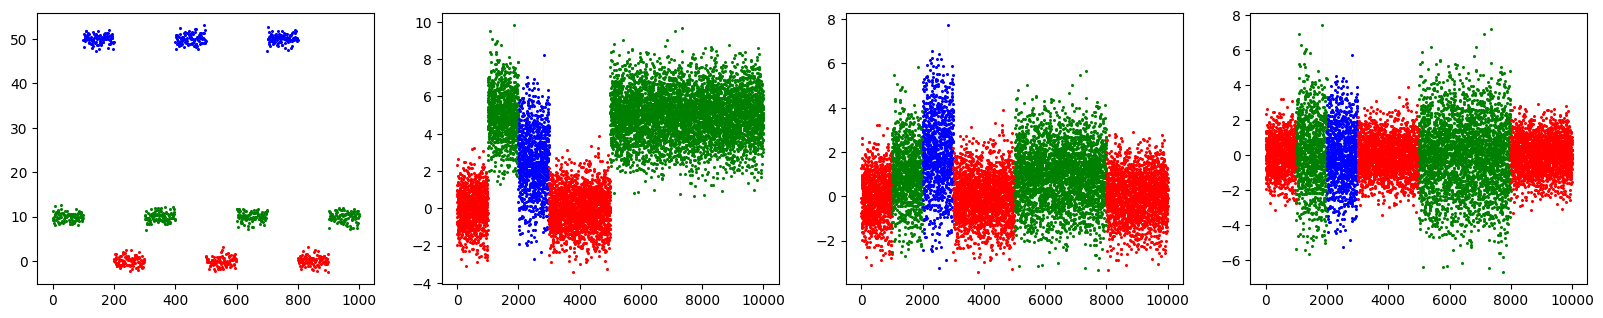

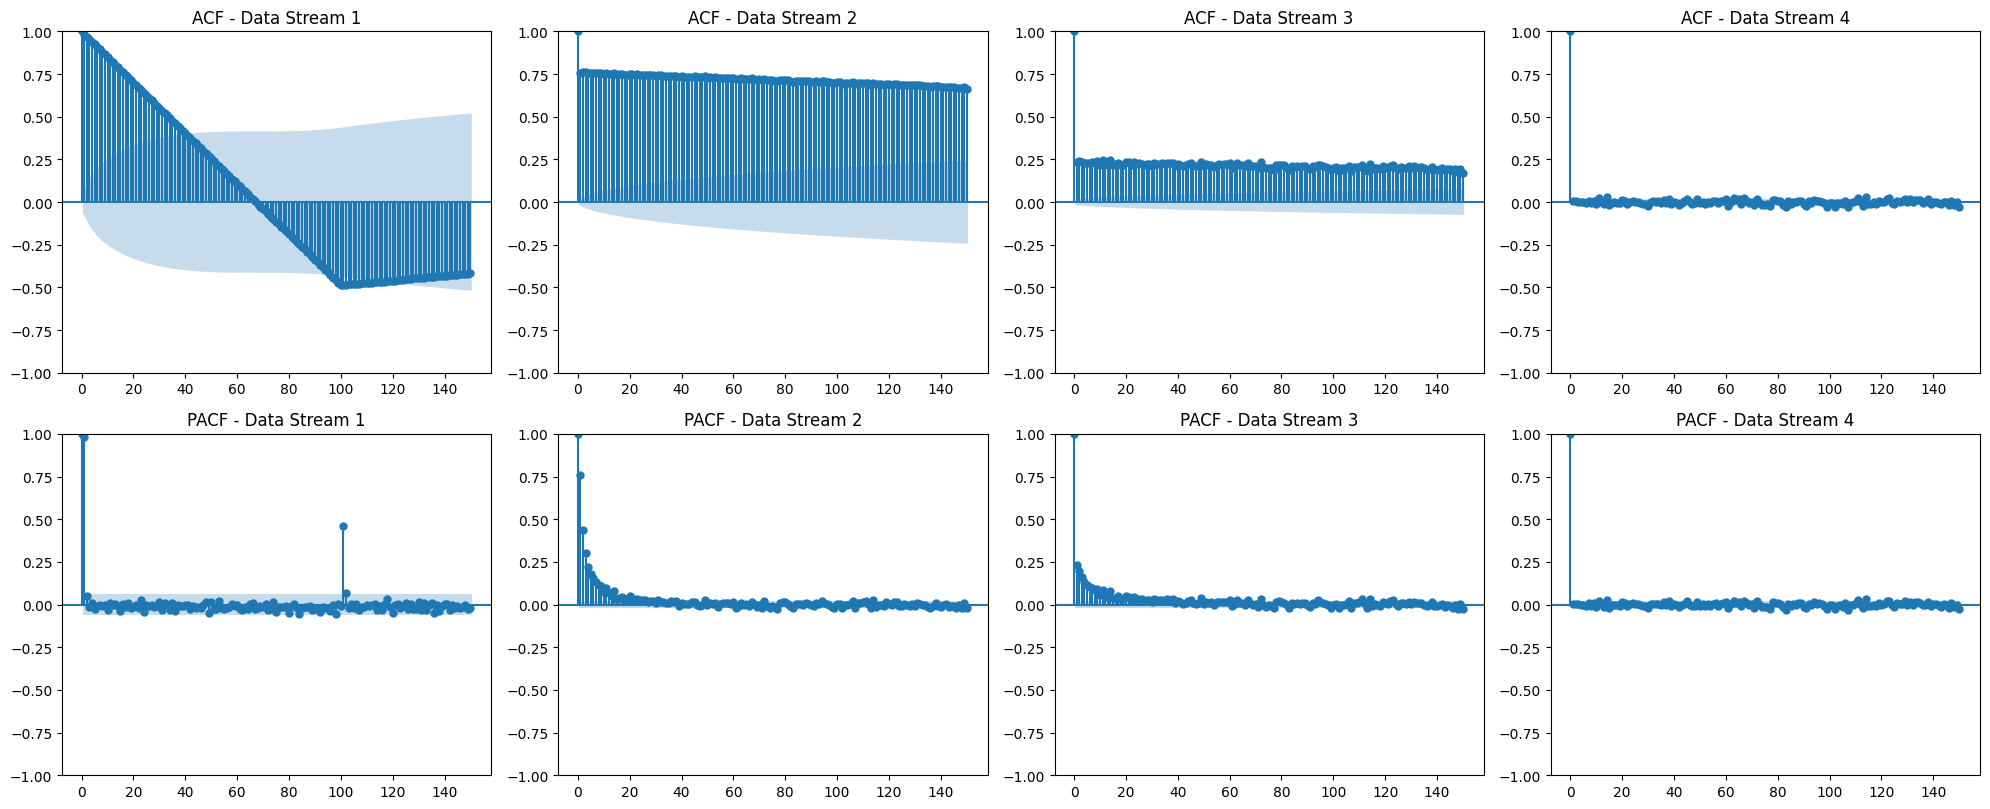

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(20, 12))

n=100
N=1000
distribution_list=['normal','normal','normal']
param_list=['0 , 1','10 , 1','50 , 1']
P=np.array([[0,1,0],[0,0,1],[1,0,0]])
data_stream1, sequence1 = generate_data_stream(distribution_list,param_list,n,N,P)

plt.subplot(3, 4, 1)
plot_data(sequence1, data_stream1, n, N)

n=1000
N=10000
distribution_list=['normal','normal','normal']
param_list=['0,1','5,1.3','2.5,1.7']
P=np.array([[0.3,0.7,0],[0,0.5,0.5],[0.4,0,0.6]])
data_stream2, sequence2 = generate_data_stream(distribution_list,param_list,n,N,P)

plt.subplot(3, 4, 2)
plot_data(sequence2, data_stream2, n, N)


n=1000
N=10000
distribution_list=['normal','normal','normal']
param_list=['0,1','1,1.3','2,1.7']
P=np.array([[0.3,0.5,0.2],[0.2,0.3,0.5],[0.4,0.3,0.3]])
data_stream3 ,sequence3 = generate_data_stream(distribution_list,param_list,n,N,P)

plt.subplot(3, 4, 3)
plot_data(sequence3, data_stream3, n, N)


n=1000
N=10000
distribution_list=['normal','normal','normal']
param_list=['0,1','0,2','0,1.7']
P=np.array([[0.3,0.5,0.2],[0.2,0.3,0.5],[0.4,0.3,0.3]])
data_stream4 ,sequence4 = generate_data_stream(distribution_list,param_list,n,N,P)

plt.subplot(3, 4, 4)
plot_data(sequence4, data_stream4, n, N)

lags_acf=150
lags_pacf=150

plt.figure(figsize=(20, 12))

n=[100,1000,1000,1000]
N=[1000,10000,10000,10000]


for i, stream in enumerate([data_stream1, data_stream2, data_stream3, data_stream4], start=1):
    plt.subplot(3, 4, i+4)
    plot_acf(stream, lags=lags_acf, ax=plt.gca())
    plt.title(f'ACF - Data Stream {i}')


for i, stream in enumerate([data_stream1, data_stream2, data_stream3, data_stream4], start=1):
    plt.subplot(3, 4, i+8)
    plot_pacf(stream, lags=lags_pacf, ax=plt.gca())
    plt.title(f'PACF - Data Stream {i}')

plt.tight_layout()

**PACF**: we observe that in all the four cases there is an exponential decay. In the first data stream there is only 1 value of partial autocorrelation that is significant in corrispondence of 100 (which is the value of n).

**ACF**: we clearly see that a lot of values for the autocorrelation are significant. A positive correlation at lag k indicates that larger current values ​​correspond to larger values ​​at the specified delay; a negative correlation indicates that the current largest values ​​correspond to the smallest values ​​at the specified delay. In this case, the autocorrelation becomes negligible after approximately $n/2$ points. In all the cases we clearly see a **linear decay** up to n. For the deterministic case, after having reached n the correlation reverses the trend. This doesn't happen on the other cases because is not true that every $n$ points the distributions changes.

[0, 1, 2, 0, 0, 1, 1, 1, 1, 1]
[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]
[0, 1, 2, 0, 0, 1, 1, 1, 0, 0]


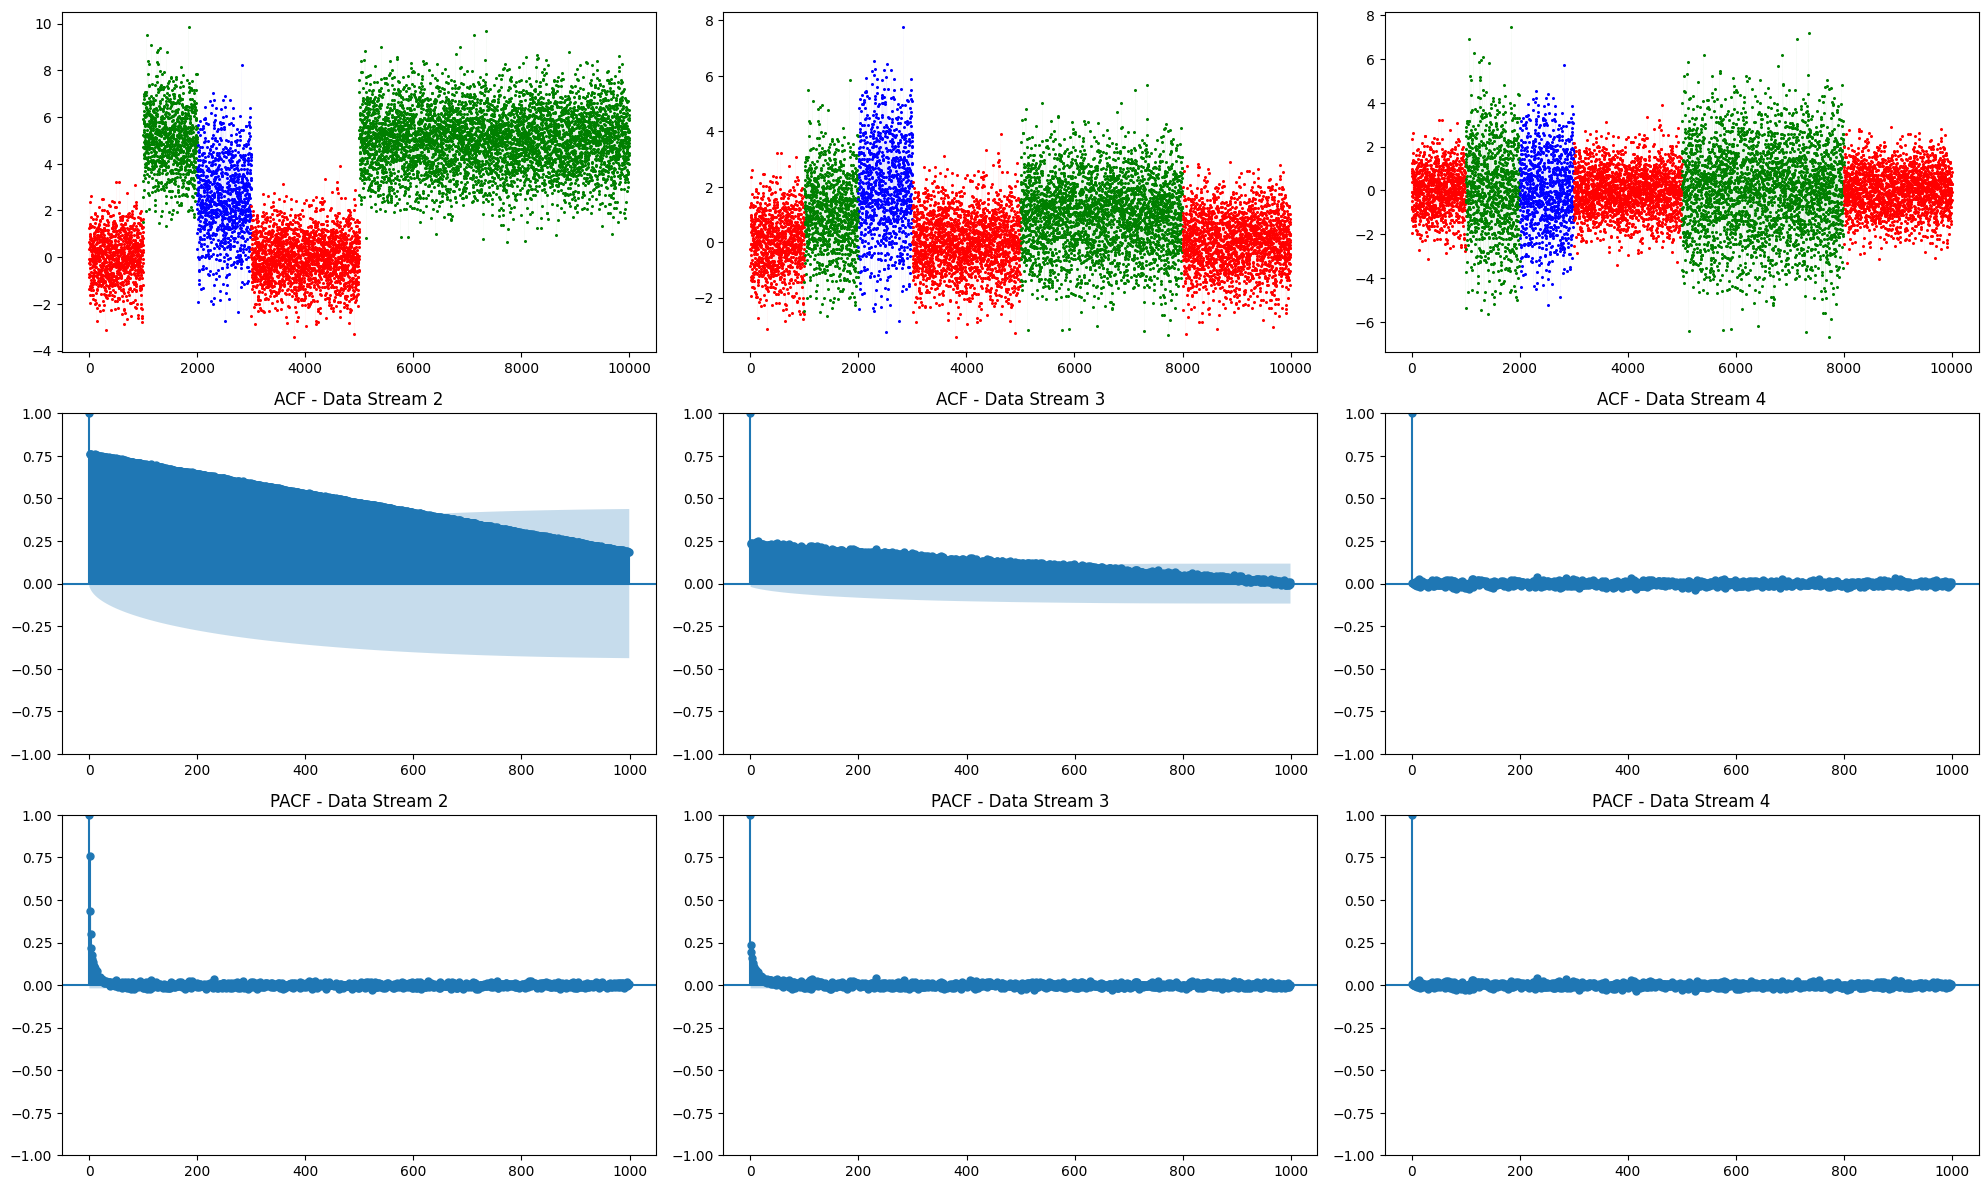

In [ ]:
plt.figure(figsize=(20, 12))

n=1000
N=10000
plt.subplot(3, 3, 1)
plot_data(sequence2, data_stream2, n, N)

plt.subplot(3, 3, 2)
plot_data(sequence3, data_stream3, n, N)

plt.subplot(3, 3, 3)
plot_data(sequence4, data_stream4, n, N)

lags_acf=1001-2
lags_pacf=1001-2


for i, stream in enumerate([ data_stream2, data_stream3, data_stream4], start=2):
    plt.subplot(3, 3, i+2)
    plot_acf(stream, lags=lags_acf, ax=plt.gca())
    plt.title(f'ACF - Data Stream {i}')


for i, stream in enumerate([ data_stream2, data_stream3, data_stream4], start=2):
    plt.subplot(3, 3, i+5)
    plot_pacf(stream, lags=lags_pacf, ax=plt.gca())
    plt.title(f'PACF - Data Stream {i}')

plt.tight_layout()

##Further material
Until now we have only analized the case in which the states are associated to gaussian distributions. Let's now make an example of a more general situation in which each state has a different distribution.

[0, 0, 1, 2, 1, 1, 2, 2, 1, 2]


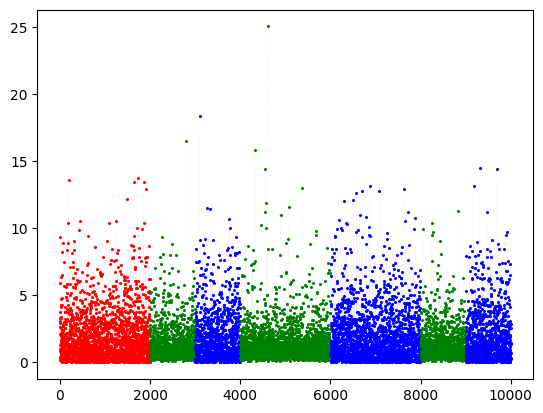

In [ ]:
n=1000
N=10000
distribution_list=['gamma','lognormal','exponential']
param_list=['1,2','0.1,0.8','2']
P=np.array([[0.3,0.5,0.2],[0.2,0.3,0.5],[0.4,0.3,0.3]])
data_stream ,sequence = generate_data_stream(distribution_list,param_list,n,N,P)
plot_data(sequence, data_stream, n, N)

In this case we are considering non negative values and the distributions are very similar. The goal is to see how the detectors behave in this situation.

**ADWIN**

In [ ]:
from river.drift import ADWIN

adwin = ADWIN()
changes=[]

for i, val in enumerate(data_stream):
    _ = adwin.update(val)
    if adwin.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 3071, input value: 0.1318384762668775
Change detected at index 4287, input value: 1.42799006525282
Change detected at index 6527, input value: 1.3097754672246624
Change detected at index 8991, input value: 0.6023419803565532


[0, 0, 1, 2, 1, 1, 2, 2, 1, 2]


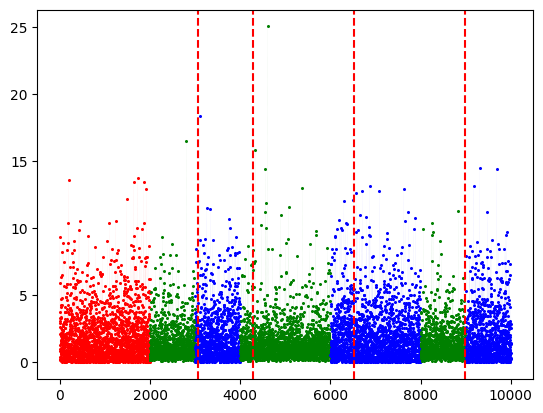

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

ADWIN is detencting some drifts: in particular the ones that pass from the lognormal to the exponential.

**Page Hinkley**

In [ ]:
from river.drift import PageHinkley

ph = PageHinkley(threshold=110)
changes=[]
for i, val in enumerate(data_stream):
    _ = ph.update(val)
    if ph.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 1689, input value: 5.561710132209026
Change detected at index 2161, input value: 0.6667530925551681
Change detected at index 3200, input value: 3.396827414046092
Change detected at index 4204, input value: 0.80603087446706
Change detected at index 6231, input value: 10.051730339151637
Change detected at index 6998, input value: 0.2685064074625273
Change detected at index 8143, input value: 0.2336052401209979
Change detected at index 9242, input value: 8.955231935433813


[0, 0, 1, 2, 1, 1, 2, 2, 1, 2]


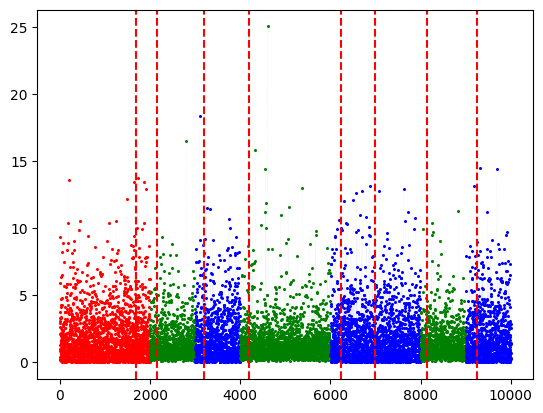

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

Here each and every drift is detected but there are also some "false positive".

**KSWIN**

In [ ]:
from river import drift

kswin = drift.KSWIN(alpha=0.0002, seed=42)
changes=[]

for i, val in enumerate(data_stream):
    _ = kswin.update(val)
    if kswin.drift_detected:
      changes.append(i)
      print(f"Change detected at index {i}, input value: {val}")

[0, 0, 1, 2, 1, 1, 2, 2, 1, 2]


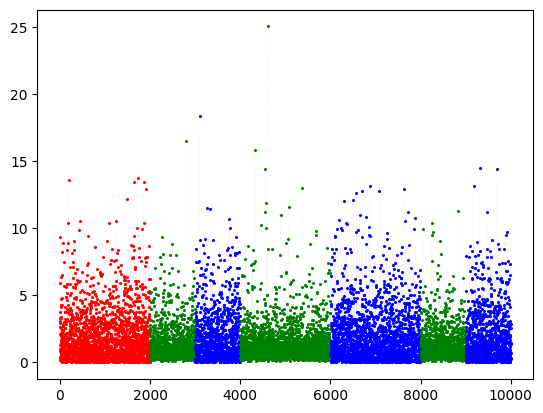

In [ ]:
plot_data(sequence, data_stream, n, N)

vertical_lines = changes  # Lista delle posizioni delle linee verticali

for line_position in vertical_lines:
    plt.axvline(x=line_position, color='red', linestyle='--')

Zero drifts detected by KSWIN.

Now we plot the ACF and PACF.

[0, 0, 1, 2, 1, 1, 2, 2, 1, 2]


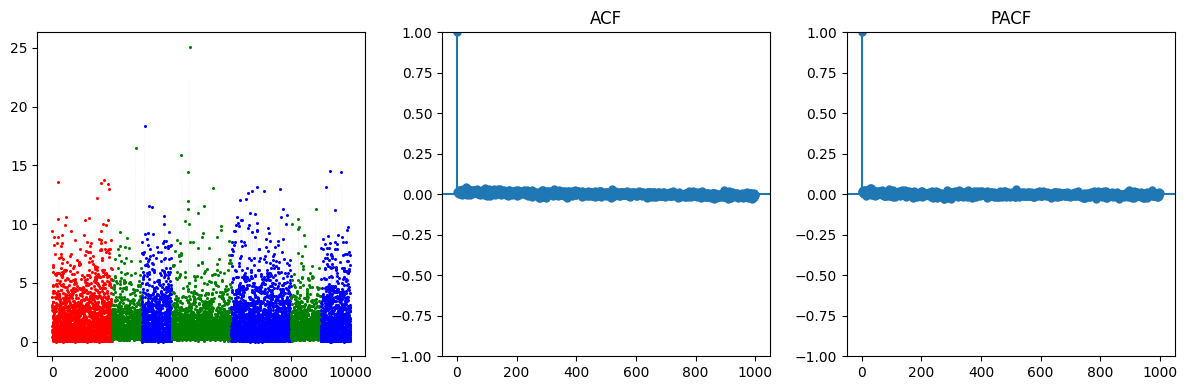

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plot_data(sequence, data_stream, n, N)

lags_acf=1001-2
lags_pacf=1001-2


plt.subplot(1,3,2)
plot_acf(data_stream, lags=lags_acf, ax=plt.gca())
plt.title(f'ACF')


plt.subplot(1,3,3)
plot_pacf(data_stream, lags=lags_pacf, ax=plt.gca())
plt.title(f'PACF')

plt.tight_layout()

Exponential decay behaviour for both the ACF and the PACF.